--- Starting Figure Generation ---
Loaded metadata from ../data/PLOWMAN/05_synthetic_leaf_data/synthetic_metadata.csv
Loaded metadata from ../data/CULTIVATED1ST/05_synthetic_leaf_data/synthetic_metadata.csv
Loaded metadata from ../data/WILDSPECIES/05_synthetic_leaf_data/synthetic_metadata.csv

Figure saved to: ../figures/Combined_Viz_Real_vs_Synthetic_GradCAM_Grid.png


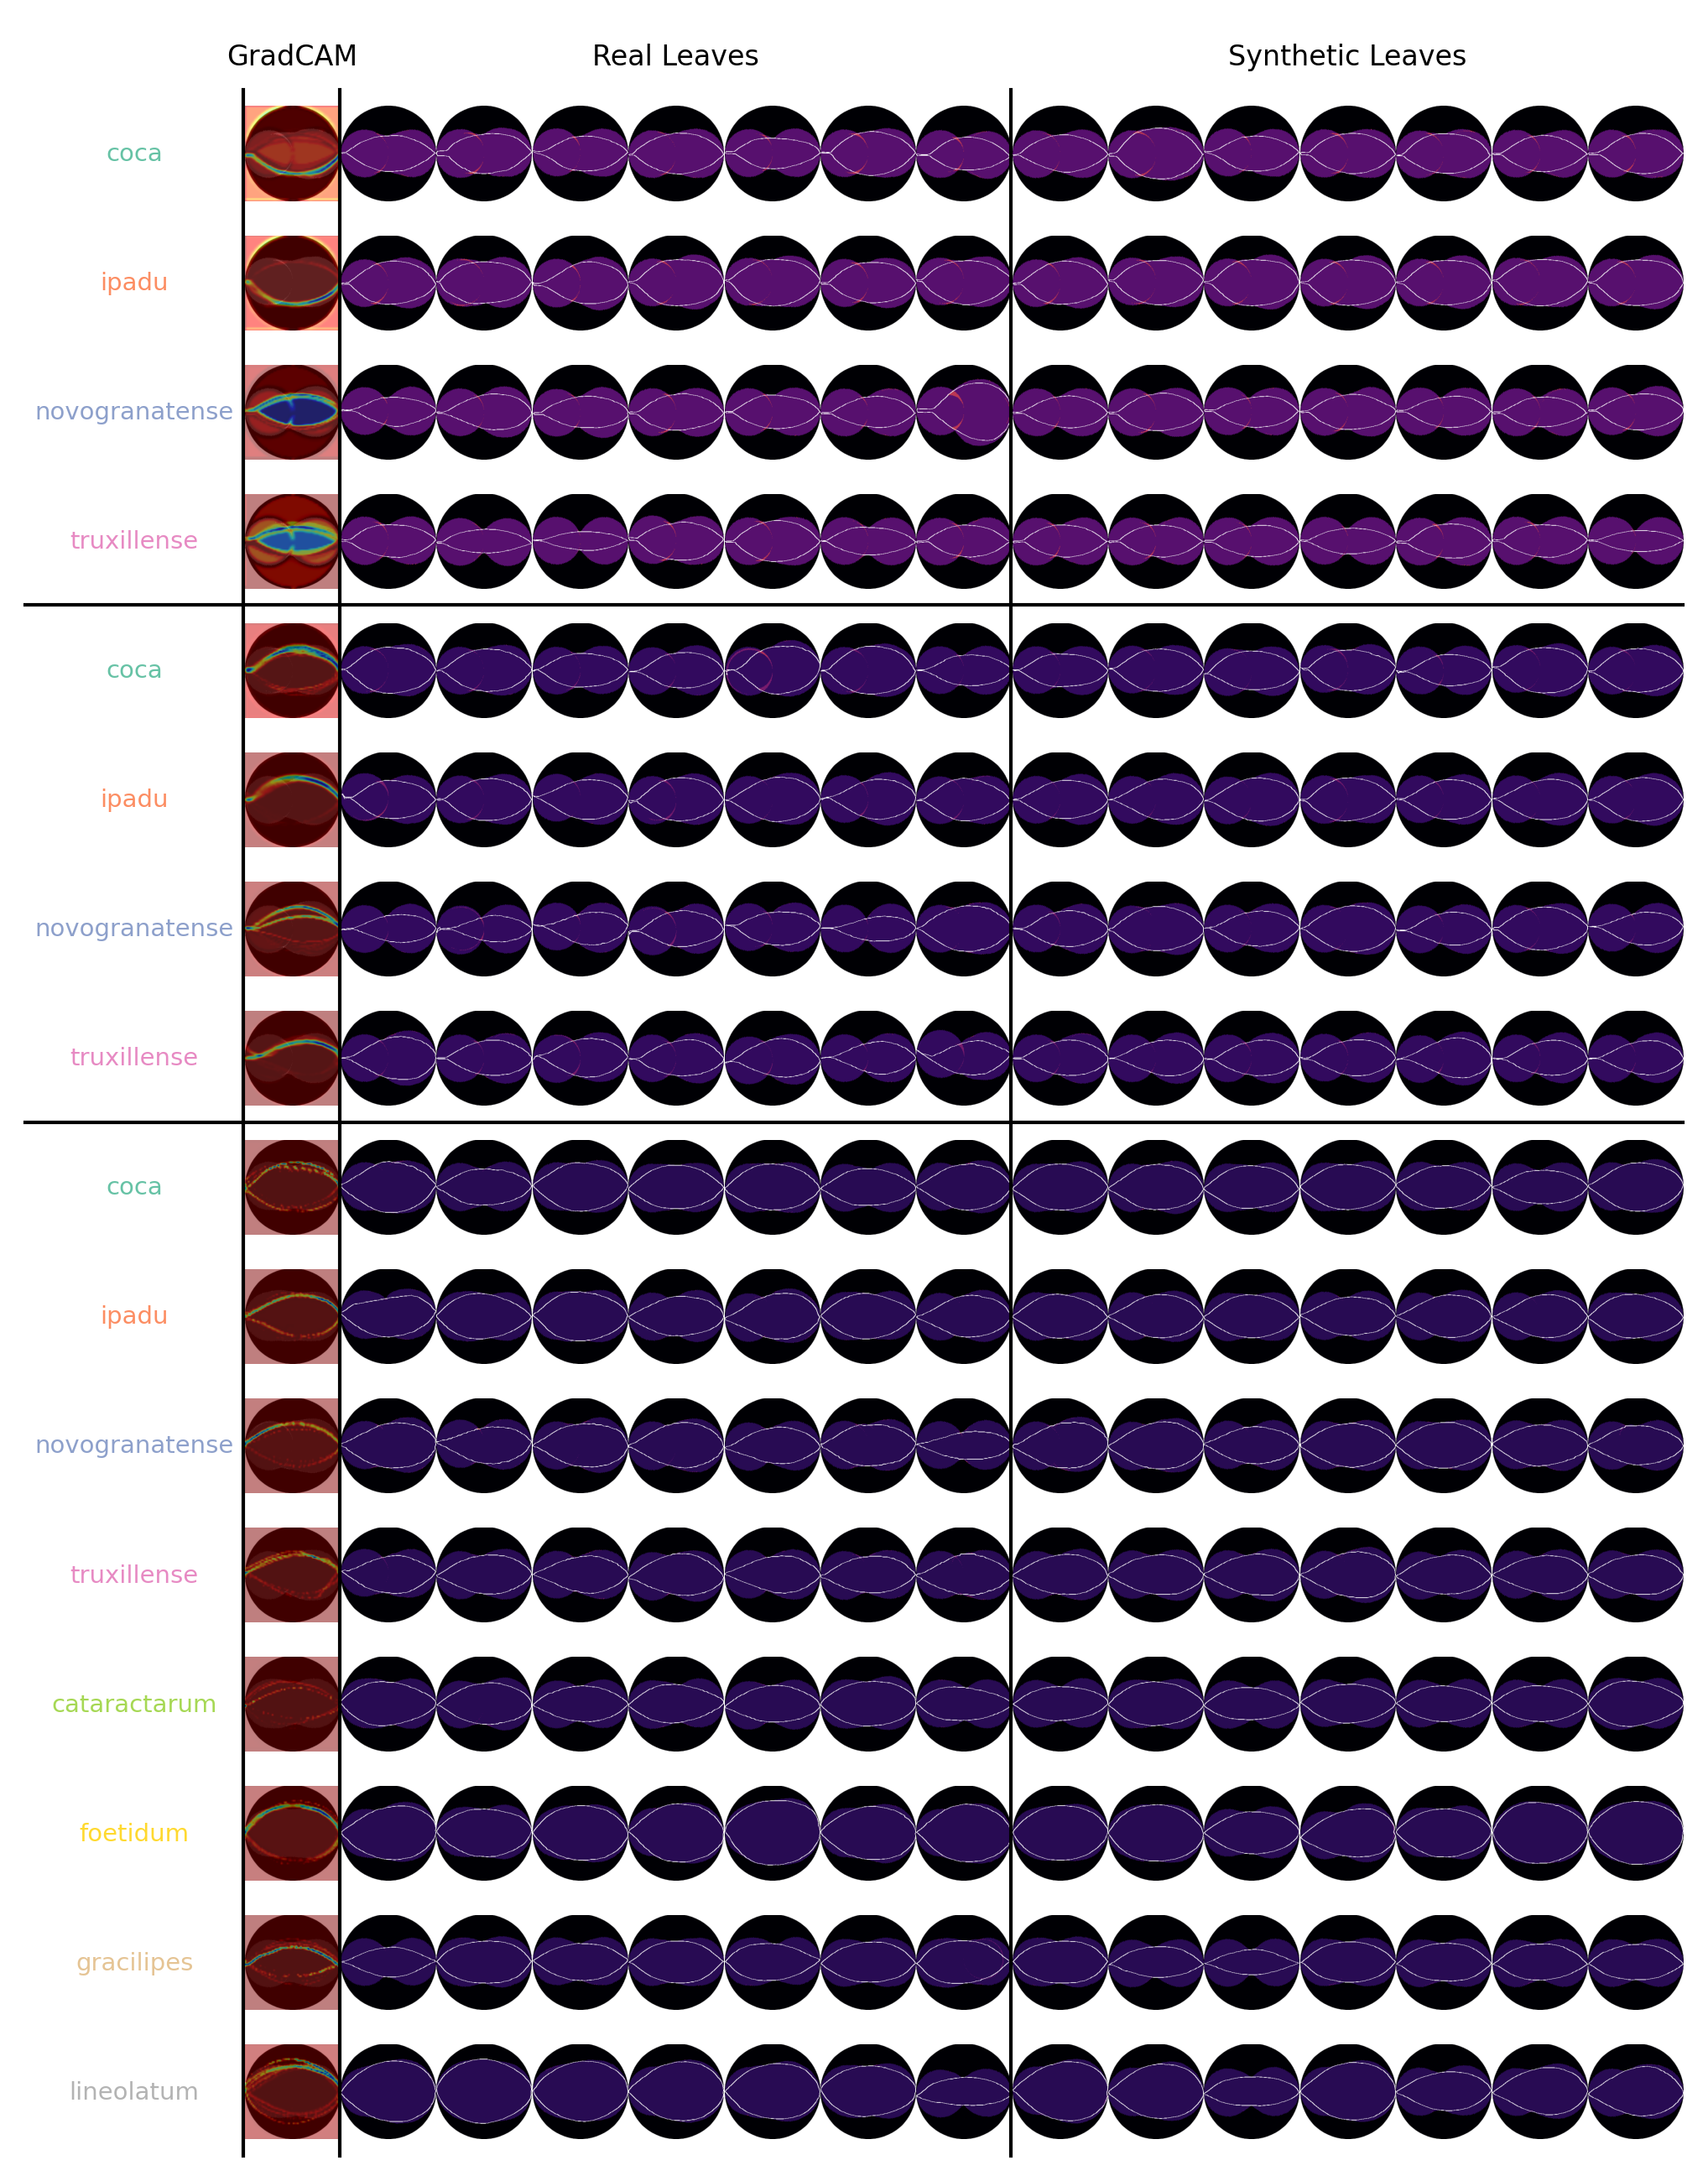

--- Figure Generation Complete ---


In [16]:
#######################
### LOAD IN MODULES ###
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns
import matplotlib.lines as lines

# Ensure consistent plotting style for publication
plt.style.use('seaborn-v0_8-deep')

############################
### GLOBAL CONFIGURATION ###
############################

# --- File Paths ---
PLOWMAN_BASE_DIR = "../data/PLOWMAN/"
CULTIVATED1ST_BASE_DIR = "../data/CULTIVATED1ST/"
WILDSPECIES_BASE_DIR = "../data/WILDSPECIES/" # Assuming 'WILDSPECIES' is correct, not 'WILDPSECIES'

# Subdirectories for synthetic data and images
SYNTHETIC_DATA_SUBDIR = "05_synthetic_leaf_data/"
COMBINED_VIZ_SUBDIR = "combined_viz/"
METADATA_FILENAME = "synthetic_metadata.csv"

# GradCAM image directories
GRADCAM_BASE_DIRS = {
    'PLOWMAN': "../data/PLOWMAN/trained_models/grad_cam_images/",
    'CULTIVATED1ST': "../data/CULTIVATED1ST/trained_models/grad_cam_images/",
    'WILDSPECIES': "../data/WILDSPECIES/trained_models/grad_cam_images/", # Corrected typo here
}

# GradCAM image filenames (consistent pattern per class)
GRADCAM_IMAGE_FILENAMES = {
    'coca': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_coca.png',
    'ipadu': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_ipadu.png',
    'novogranatense': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_novogranatense.png',
    'truxillense': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_truxillense.png',
    'cataractarum': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_cataractarum.png',
    'foetidum': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_foetidum.png',
    'gracilipes': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_gracilipes.png',
    'lineolatum': 'ECT_Mask_2Channel_CNN_Ensemble_Improved_GradCAM_lineolatum.png',
}

# Output directory for figures
FIGURES_OUTPUT_DIR = "../figures/"
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- Figure Parameters ---
FIGURE_WIDTH_INCHES = 8.5
FIGURE_HEIGHT_INCHES = 11.0
DPI = 300

# Number of random examples to show for Real and Synthetic categories
NUM_EXAMPLES_PER_TYPE = 7 # <-- Easily adjustable parameter

# Font sizes
TITLE_FONTSIZE = 8 # For "Real Leaves" / "Synthetic Leaves" / "GradCAM"
CLASS_LABEL_FONTSIZE = 7 # For class names on the far left

# --- Global Color Palette (reused from previous figure) ---
# Full 8-class order (used for WildSpecies and for generating the global palette)
FULL_8CLASS_LEGEND_ORDER = [
    'coca', 'ipadu', 'novogranatense', 'truxillense',
    'cataractarum', 'foetidum', 'gracilipes', 'lineolatum'
]

# Dynamically create a palette for all 8 classes using Set2 (per user feedback)
PALETTE = sns.color_palette('Set2', n_colors=len(FULL_8CLASS_LEGEND_ORDER))
CLASS_COLORS = {cls: PALETTE[i] for i, cls in enumerate(FULL_8CLASS_LEGEND_ORDER)}

# Dataset order for rows
DATASET_ORDER = ['PLOWMAN', 'CULTIVATED1ST', 'WILDSPECIES']

#########################
### HELPER FUNCTIONS ###
#########################

def load_synthetic_metadata(base_dataset_dir):
    """
    Loads synthetic metadata for a given dataset and returns the DataFrame
    along with the base directory for constructing full image paths.
    """
    synth_data_dir = os.path.join(base_dataset_dir, SYNTHETIC_DATA_SUBDIR)
    metadata_path = os.path.join(synth_data_dir, METADATA_FILENAME)
    
    if not os.path.exists(metadata_path):
        print(f"Error: Metadata file not found at {metadata_path}")
        return None, None
        
    df = pd.read_csv(metadata_path)
    # Ensure 'is_real' is boolean
    df['is_real'] = df['is_real'].astype(bool)
    
    print(f"Loaded metadata from {metadata_path}")
    return df, synth_data_dir

def get_image_paths_for_class(metadata_df, base_synth_dir, class_label, is_real, num_examples):
    """
    Filters metadata for a specific class and 'is_real' status,
    randomly selects image paths, and constructs full paths.
    """
    # Filter for the specific class and real/synthetic status
    filtered_df = metadata_df[
        (metadata_df['class_label'] == class_label) & 
        (metadata_df['is_real'] == is_real)
    ]
    
    # Randomly sample paths, or take all if fewer than num_examples are available
    if len(filtered_df) > num_examples:
        selected_rows = random.sample(filtered_df.index.tolist(), num_examples)
        selected_df = filtered_df.loc[selected_rows]
    else:
        selected_df = filtered_df
    
    full_image_paths = [
        os.path.join(base_synth_dir, row['file_combined_viz']) 
        for idx, row in selected_df.iterrows()
    ]
    
    return full_image_paths

##########################
### MAIN FIGURE SCRIPT ###
##########################

print("--- Starting Figure Generation ---")

# --- 1. Load All Data ---
all_dataset_data = {}
for dataset_name in DATASET_ORDER:
    base_dir = globals()[f"{dataset_name.upper()}_BASE_DIR"] # Get the base directory variable
    metadata_df, synth_dir = load_synthetic_metadata(base_dir)
    if metadata_df is not None:
        # Filter and order classes based on FULL_8CLASS_LEGEND_ORDER
        # This will be the actual list of classes we iterate through for this dataset
        ordered_available_classes = [
            cls for cls in FULL_8CLASS_LEGEND_ORDER if cls in metadata_df['class_label'].unique()
        ]
        all_dataset_data[dataset_name] = {
            'df': metadata_df,
            'synth_dir': synth_dir,
            'ordered_classes': ordered_available_classes, # Use filtered and ordered classes
            'gradcam_dir': GRADCAM_BASE_DIRS.get(dataset_name) # Get the specific GradCAM directory
        }
    else:
        print(f"Skipping {dataset_name} due to missing metadata.")

# --- 2. Calculate Grid Dimensions ---
total_class_rows = sum(len(data['ordered_classes']) for data in all_dataset_data.values()) 
total_gs_rows = total_class_rows + 1 # +1 for the top titles row (gs row index 0)

# 1 (Class Label) + 1 (GradCAM) + NUM_EXAMPLES_PER_TYPE (real) + NUM_EXAMPLES_PER_TYPE (synthetic)
total_gs_cols = 1 + 1 + NUM_EXAMPLES_PER_TYPE + NUM_EXAMPLES_PER_TYPE 

# Define column width ratios: Class Label, GradCAM, Image (standard)
COL_LABEL_RATIO = 2.3 # Adjusted by user
COL_GRADCAM_RATIO = 1.0 # Initial value, user can fine-tune
COL_IMAGE_RATIO = 1.0

# Corrected order of column ratios
gs_width_ratios = [COL_LABEL_RATIO, COL_GRADCAM_RATIO] + [COL_IMAGE_RATIO] * NUM_EXAMPLES_PER_TYPE * 2

# Define row height ratios: Top Title Row (short) vs. Image Row (standard)
ROW_TITLE_RATIO = 0.5
ROW_IMAGE_RATIO = 1.0
gs_height_ratios = [ROW_TITLE_RATIO] + [ROW_IMAGE_RATIO] * total_class_rows

# --- 3. Set up the Figure and GridSpec ---
fig = plt.figure(figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES), dpi=DPI,
                 constrained_layout=False)

gs = fig.add_gridspec(
    nrows=total_gs_rows, ncols=total_gs_cols,
    width_ratios=gs_width_ratios,
    height_ratios=gs_height_ratios,
    wspace=0.01, # Minimal horizontal space between subplots
    hspace=0.01  # Minimal vertical space between subplots
)

# Set padding for constrained_layout-like behavior without full constrained_layout
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, wspace=0.01, hspace=0.01)

# Initialize a dictionary to store all axes by their (gs_row_idx, gs_col_idx) for precise positioning later
gs_axes = {}

# --- 4. Add Top Titles ---
# GradCAM title (now second column title)
ax_gradcam_title = fig.add_subplot(gs[0, 1]) # Column 1 for GradCAM
ax_gradcam_title.text(0.5, 0.5, "GradCAM", ha='center', va='center', fontsize=TITLE_FONTSIZE, transform=ax_gradcam_title.transAxes)
ax_gradcam_title.axis('off')
gs_axes[(0, 1)] = ax_gradcam_title 

# Real Leaves title spans over the real image columns (now starting at gs_col_idx = 2)
ax_real_title = fig.add_subplot(gs[0, 2 : 2 + NUM_EXAMPLES_PER_TYPE])
ax_real_title.text(0.5, 0.5, "Real Leaves", ha='center', va='center', fontsize=TITLE_FONTSIZE, transform=ax_real_title.transAxes)
ax_real_title.axis('off')
gs_axes[(0, 2)] = ax_real_title 

# Synthetic Leaves title spans over the synthetic image columns (now starting at gs_col_idx = 2 + NUM_EXAMPLES_PER_TYPE)
ax_synthetic_title = fig.add_subplot(gs[0, 2 + NUM_EXAMPLES_PER_TYPE : ])
ax_synthetic_title.text(0.5, 0.5, "Synthetic Leaves", ha='center', va='center', fontsize=TITLE_FONTSIZE, transform=ax_synthetic_title.transAxes)
ax_synthetic_title.axis('off')
gs_axes[(0, 2 + NUM_EXAMPLES_PER_TYPE)] = ax_synthetic_title 

# --- 5. Populate Image Grid ---
current_data_row_idx = 0 # This index tracks the *data row* (starts from 0, maps to gs row index 1 and onwards)
dataset_end_gs_row_indices = {} # Store the gs_row_index where each dataset's data block ends

for dataset_name in DATASET_ORDER:
    data = all_dataset_data.get(dataset_name)
    if data is None:
        continue # Skip if data failed to load

    for class_label in data['ordered_classes']: # Iterate ONLY through the actual, ordered classes for this dataset
        gs_row_for_data = current_data_row_idx + 1 # Calculate actual GridSpec row index

        # --- Class Label (first column, index 0) ---
        ax_label = fig.add_subplot(gs[gs_row_for_data, 0])
        label_color = CLASS_COLORS.get(class_label, 'black')
        # Centered the text here: changed x from 0.05 to 0.5 and ha from 'left' to 'center'
        ax_label.text(0.5, 0.5, class_label, ha='center', va='center', 
                      fontsize=CLASS_LABEL_FONTSIZE, color=label_color,
                      transform=ax_label.transAxes)
        ax_label.axis('off')
        ax_label.set_xlim(0, 1) 
        ax_label.set_ylim(0, 1)
        gs_axes[(gs_row_for_data, 0)] = ax_label # Store reference

        # --- GradCAM Image (second column, index 1) ---
        ax_gradcam = fig.add_subplot(gs[gs_row_for_data, 1])
        gradcam_path = os.path.join(data['gradcam_dir'], GRADCAM_IMAGE_FILENAMES.get(class_label, ''))
        try:
            gradcam_img = mpimg.imread(gradcam_path)
            ax_gradcam.imshow(gradcam_img)
        except (FileNotFoundError, OSError): # OSError handles cases like corrupted or unreadable images
            ax_gradcam.text(0.5, 0.5, "GradCAM N/A", ha='center', va='center', fontsize=6, color='red')
        ax_gradcam.axis('off')
        ax_gradcam.set_aspect('equal')
        gs_axes[(gs_row_for_data, 1)] = ax_gradcam # Store reference

        # --- Real Images (starting from third column, index 2) ---
        real_image_paths = get_image_paths_for_class(
            data['df'], data['synth_dir'], class_label, is_real=True, num_examples=NUM_EXAMPLES_PER_TYPE
        )
        
        for i, img_path in enumerate(real_image_paths):
            ax = fig.add_subplot(gs[gs_row_for_data, 2 + i])
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
            except FileNotFoundError:
                ax.text(0.5, 0.5, "Image N/A", ha='center', va='center', fontsize=6, color='red')
            ax.axis('off')
            ax.set_aspect('equal')
            gs_axes[(gs_row_for_data, 2 + i)] = ax # Store reference

        # Fill remaining real image slots with empty axes if fewer than NUM_EXAMPLES_PER_TYPE
        for i in range(len(real_image_paths), NUM_EXAMPLES_PER_TYPE):
            ax = fig.add_subplot(gs[gs_row_for_data, 2 + i])
            ax.axis('off')
            ax.set_aspect('equal')
            gs_axes[(gs_row_for_data, 2 + i)] = ax # Store reference

        # --- Synthetic Images (starting after real images) ---
        synthetic_image_paths = get_image_paths_for_class(
            data['df'], data['synth_dir'], class_label, is_real=False, num_examples=NUM_EXAMPLES_PER_TYPE
        )

        for i, img_path in enumerate(synthetic_image_paths):
            ax = fig.add_subplot(gs[gs_row_for_data, 2 + NUM_EXAMPLES_PER_TYPE + i])
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
            except FileNotFoundError:
                ax.text(0.5, 0.5, "Image N/A", ha='center', va='center', fontsize=6, color='red')
            ax.axis('off')
            ax.set_aspect('equal')
            gs_axes[(gs_row_for_data, 2 + NUM_EXAMPLES_PER_TYPE + i)] = ax # Store reference

        # Fill remaining synthetic image slots with empty axes if fewer than NUM_EXAMPLES_PER_TYPE
        for i in range(len(synthetic_image_paths), NUM_EXAMPLES_PER_TYPE):
            ax = fig.add_subplot(gs[gs_row_for_data, 2 + NUM_EXAMPLES_PER_TYPE + i])
            ax.axis('off')
            ax.set_aspect('equal')
            gs_axes[(gs_row_for_data, 2 + NUM_EXAMPLES_PER_TYPE + i)] = ax # Store reference
        
        current_data_row_idx += 1 # Move to the next class row in the overall grid
    
    # Store the actual gs_row_index where this dataset's block ends
    dataset_end_gs_row_indices[dataset_name] = current_data_row_idx


# --- 6. Draw Separator Lines (using precise subplot positions) ---

# Get boundary axes for vertical lines
# Top-left of the overall image grid (e.g., first label of first class in PLOWMAN block)
ax_top_left_overall_grid = gs_axes[(1, 0)] 
# Bottom-left of the overall image grid (e.g., first label of last class in WILDSPECIES block)
ax_bottom_left_overall_grid = gs_axes[(total_gs_rows - 1, 0)] 

# Vertical Line separating Class Labels and GradCAM (now at right edge of column 0)
vline_label_gradcam_x_pos = ax_top_left_overall_grid.get_position().x1 
vline_y_start = ax_top_left_overall_grid.get_position().y1 # Top of the image grid
vline_y_end = ax_bottom_left_overall_grid.get_position().y0 # Bottom of the last image row

vline_label_gradcam = lines.Line2D([vline_label_gradcam_x_pos, vline_label_gradcam_x_pos], [vline_y_end, vline_y_start], 
                                   transform=fig.transFigure, color='black', linestyle='-', linewidth=1.0, zorder=10)
fig.add_artist(vline_label_gradcam)

# Vertical Line separating GradCAM and Real Leaves (now at right edge of column 1)
ax_gradcam_last_first_row = gs_axes[(1, 1)] # GradCAM column, first data row
vline_gradcam_real_x_pos = ax_gradcam_last_first_row.get_position().x1
vline_gradcam_real = lines.Line2D([vline_gradcam_real_x_pos, vline_gradcam_real_x_pos], [vline_y_end, vline_y_start],
                                  transform=fig.transFigure, color='black', linestyle='-', linewidth=1.0, zorder=10)
fig.add_artist(vline_gradcam_real)


# Vertical Line separating Real and Synthetic (now at right edge of last real image column)
# This is at column index 2 + NUM_EXAMPLES_PER_TYPE - 1 (the last index of the real image block)
ax_last_real_in_first_row = gs_axes[(1, 2 + NUM_EXAMPLES_PER_TYPE - 1)] 
vline_real_synth_x_pos = ax_last_real_in_first_row.get_position().x1
vline_real_synth = lines.Line2D([vline_real_synth_x_pos, vline_real_synth_x_pos], [vline_y_end, vline_y_start],
                                transform=fig.transFigure, color='black', linestyle='-', linewidth=1.0, zorder=10)
fig.add_artist(vline_real_synth)


# Horizontal Lines between Datasets
# Get boundary axes for horizontal lines x-span
hline_x_start = ax_top_left_overall_grid.get_position().x0 # Left edge of the Class Label column (index 0)
# Last synthetic image of any row (e.g. first class in PLOWMAN block)
ax_last_synth_in_first_row = gs_axes[(1, total_gs_cols - 1)] 
hline_x_end = ax_last_synth_in_first_row.get_position().x1 # Right edge of last image column

# Line after PLOWMAN dataset
plowman_last_gs_row = dataset_end_gs_row_indices['PLOWMAN'] 
ax_plowman_hline_y_pivot = gs_axes[(plowman_last_gs_row, 0)] # Use the label axis of the last PLOWMAN row
hline_y_pos_plowman = ax_plowman_hline_y_pivot.get_position().y0

hline_plowman = lines.Line2D([hline_x_start, hline_x_end], 
                             [hline_y_pos_plowman, hline_y_pos_plowman],
                             transform=fig.transFigure, color='black', linestyle='-', linewidth=1.0, zorder=10)
fig.add_artist(hline_plowman)

# Line after CULTIVATED1ST dataset
cultivated1st_last_gs_row = dataset_end_gs_row_indices['CULTIVATED1ST']
ax_cultivated1st_hline_y_pivot = gs_axes[(cultivated1st_last_gs_row, 0)] # Use the label axis of the last CULTIVATED1ST row
hline_y_pos_cultivated1st = ax_cultivated1st_hline_y_pivot.get_position().y0

hline_cultivated1st = lines.Line2D([hline_x_start, hline_x_end], 
                                   [hline_y_pos_cultivated1st, hline_y_pos_cultivated1st],
                                   transform=fig.transFigure, color='black', linestyle='-', linewidth=1.0, zorder=10)
fig.add_artist(hline_cultivated1st)


# --- 7. Save and Show Figure ---
output_filename = "Combined_Viz_Real_vs_Synthetic_GradCAM_Grid.png"
plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, output_filename), dpi=DPI, bbox_inches='tight', pad_inches=0.05)
print(f"\nFigure saved to: {os.path.join(FIGURES_OUTPUT_DIR, output_filename)}")

plt.show()
print("--- Figure Generation Complete ---")